In [33]:
import numpy as np
import cv2
from pyaqua3ddev.image.image_processors import RawProcessor
from pathlib import Path
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte

In [34]:
rows = 10
cols = 14
square_size = 42

In [ ]:
input_directory = Path("/mnt/fishsense_data/2025.02.27.FishSense.Canyonview/ED-00/FSL-07D/E4ECalib/Laser")
files = list(input_directory.rglob("*.ORF"))

output_directory = Path("/mnt/fishsense_data/2025.02.27.FishSense.Canyonview/output/FSL-07D/E4ECalib/Laser")
output_directory.mkdir(exist_ok=True)


In [36]:
raw_processor = RawProcessor()

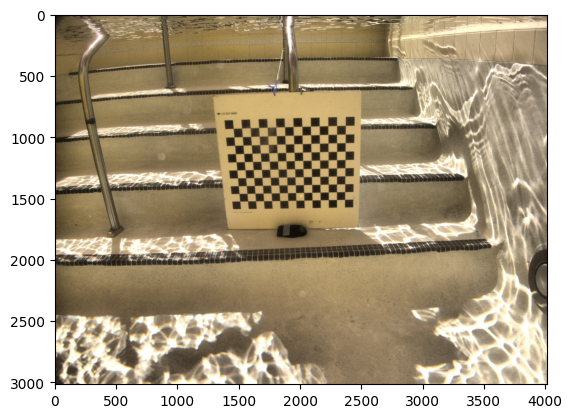

In [37]:
images = [img_as_ubyte(raw_processor.process(f)) for f in files]

plt.imshow(images[0])

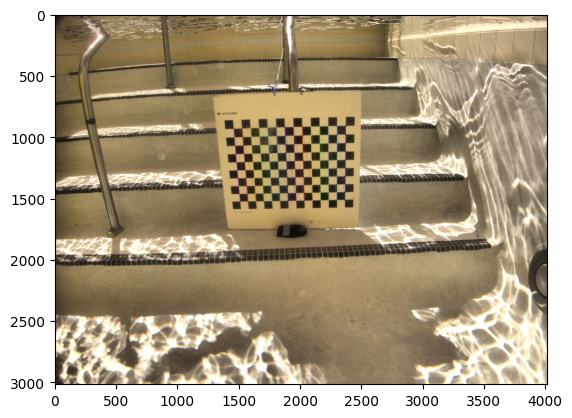

In [38]:
corners_rough_list = []

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
for idx, (file, image) in enumerate(zip(files, images)):
    target = output_directory / file.parent.relative_to(input_directory) / "rough" / f"{file.stem}.png"
    target.parent.mkdir(exist_ok=True, parents=True)

    # convert to grayscale
    gray = cv2.cvtColor(cv2.UMat(image), cv2.COLOR_BGR2GRAY)

    # find the checkerboard
    ret, corners_rough = cv2.findChessboardCorners(
        gray, (rows, cols), None
    )

    debug_image = cv2.drawChessboardCorners(image, (rows, cols), corners_rough.get(), ret)
    cv2.imwrite(target.absolute().as_posix(), debug_image)

    corners_rough_list.append(corners_rough)

    if idx == 0:
        plt.imshow(debug_image)
        plt.show()

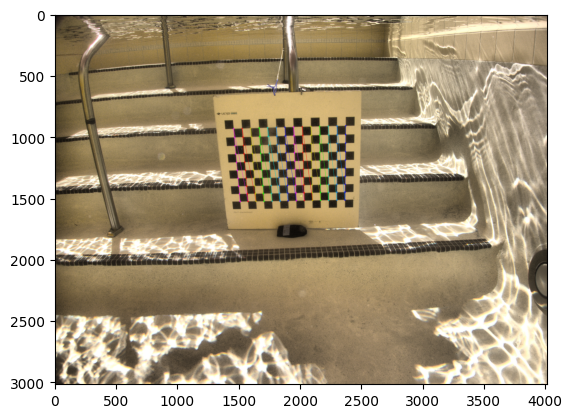

In [39]:
for idx, (corners_rough, file, image) in enumerate(zip(corners_rough_list, files, images)):
    target = output_directory / file.parent.relative_to(input_directory) / "refined" / f"{file.stem}.png"
    target.parent.mkdir(exist_ok=True, parents=True)

    # Convolution size used to improve corner detection. Don't make this too large.
    conv_size = (11, 11)

    # opencv can attempt to improve the checkerboard coordinates
    corners = cv2.cornerSubPix(gray, corners_rough, conv_size, (-1, -1), criteria)

    debug_image = cv2.drawChessboardCorners(image, (rows, cols), corners.get(), ret)
    cv2.imwrite(target.absolute().as_posix(), debug_image)
    
    if idx == 0:
        plt.imshow(debug_image)
        plt.show()